In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random

In [2]:


# Pretext augmentations for MOCO
moco_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Dataset loading without labels (ImageFolder still uses them but we ignore)
class MoCoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.transform = transform

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        return self.transform(img), self.transform(img)  # return two views

    def __len__(self):
        return len(self.dataset)

pretext_dataset = MoCoDataset("/content/drive/MyDrive/Colab Notebooks/Fish Classifications/Fish Data_Raw", moco_transform)
pretext_loader = DataLoader(pretext_dataset, batch_size=128, shuffle=True, num_workers=2)


In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Simple encoder using ResNet18
from torchvision.models import resnet18

class MoCo(nn.Module):
    def __init__(self, feature_dim=128):
        super(MoCo, self).__init__()
        self.encoder_q = self._get_encoder(feature_dim)
        self.encoder_k = self._get_encoder(feature_dim)
        self._momentum = 0.999
        self._queue_size = 8192
        self.register_buffer("queue", torch.randn(feature_dim, self._queue_size))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    def _get_encoder(self, feature_dim):
        model = resnet18(pretrained=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, feature_dim)
        )
        return model

    @torch.no_grad()
    def _momentum_update(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self._momentum + param_q.data * (1. - self._momentum)
    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        # keys: [B, D]
        keys = keys.detach()
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        queue_size = self.queue.shape[1]

        if ptr + batch_size <= queue_size:
            self.queue[:, ptr:ptr + batch_size] = keys.T
        else:
            overflow = (ptr + batch_size) - queue_size
            self.queue[:, ptr:] = keys[:batch_size - overflow].T
            self.queue[:, :overflow] = keys[batch_size - overflow:].T

        ptr = (ptr + batch_size) % queue_size
        self.queue_ptr[0] = ptr


    def forward(self, im_q, im_k):
      batch_size = im_q.size(0)

      # Compute query features
      q = self.encoder_q(im_q)  # [B, D]
      q = F.normalize(q, dim=1)

      # Compute key features (momentum encoder)
      with torch.no_grad():
          self._momentum_update()
          k = self.encoder_k(im_k)
          k = F.normalize(k, dim=1)

    # Positive logits: [B, 1]
      l_pos = torch.bmm(q.view(batch_size, 1, -1), k.view(batch_size, -1, 1)).squeeze(-1).squeeze(-1)  # [B]

    # Negative logits: [B, K]
      queue = self.queue.clone().detach()
      l_neg = torch.mm(q, queue)  # [B, K]

    # Combine: [B, 1+K]
      logits = torch.cat([l_pos.unsqueeze(1), l_neg], dim=1)

    # Labels: positives are at index 0
      labels = torch.zeros(batch_size, dtype=torch.long).to(q.device)

    # Update the queue
      self._dequeue_and_enqueue(k)

      return logits, labels




In [4]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints'

import os
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MoCo().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Ensure the save path exists
os.makedirs(save_path, exist_ok=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:


EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0
    batch_count = 0
    loop = tqdm(pretext_loader, leave=False)

    for im_q, im_k in loop:
        im_q, im_k = im_q.to(device), im_k.to(device)
        logits, labels = model(im_q, im_k)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1

        loop.set_description(f"Epoch [{epoch}/{EPOCHS}]")
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / batch_count
    print(f"Epoch {epoch}: Average Loss = {avg_loss:.4f}")

    # Save encoder every 5 epochs
    if epoch % 5 == 0:
        model_file = os.path.join(save_path, f"moco_encoder_epoch{epoch}.pth")
        torch.save(model.encoder_q.state_dict(), model_file)
        print(f"Encoder saved at epoch {epoch}: {model_file}")


Epoch 1: Average Loss = 8.6506


Epoch 2: Average Loss = 8.7636


Epoch 3: Average Loss = 8.6379


Epoch 4: Average Loss = 8.5876


Epoch 5: Average Loss = 8.5565
Encoder saved at epoch 5: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch5.pth


Epoch 6: Average Loss = 8.5319


Epoch 7: Average Loss = 8.5096


Epoch 8: Average Loss = 8.4839


Epoch 9: Average Loss = 8.4666


Epoch 10: Average Loss = 8.4517
Encoder saved at epoch 10: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch10.pth


Epoch 11: Average Loss = 8.4353


Epoch 12: Average Loss = 8.4202


Epoch 13: Average Loss = 8.4060


Epoch 14: Average Loss = 8.3947


Epoch 15: Average Loss = 8.3813
Encoder saved at epoch 15: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch15.pth


Epoch 16: Average Loss = 8.3751


Epoch 17: Average Loss = 8.3652


Epoch 18: Average Loss = 8.3541


Epoch 19: Average Loss = 8.3454


Epoch 20: Average Loss = 8.3379
Encoder saved at epoch 20: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch20.pth


Epoch 21: Average Loss = 8.3314


Epoch 22: Average Loss = 8.3233


Epoch 23: Average Loss = 8.3147


Epoch 24: Average Loss = 8.3097


Epoch 25: Average Loss = 8.3000
Encoder saved at epoch 25: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch25.pth


Epoch 26: Average Loss = 8.2981


Epoch 27: Average Loss = 8.2925


Epoch 28: Average Loss = 8.2882


Epoch 29: Average Loss = 8.2811


Epoch 30: Average Loss = 8.2800
Encoder saved at epoch 30: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch30.pth


Epoch 31: Average Loss = 8.2748


Epoch 32: Average Loss = 8.2718


Epoch 33: Average Loss = 8.2659


Epoch 34: Average Loss = 8.2621


Epoch 35: Average Loss = 8.2601
Encoder saved at epoch 35: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch35.pth


Epoch 36: Average Loss = 8.2575


Epoch 37: Average Loss = 8.2519


Epoch 38: Average Loss = 8.2507


Epoch 39: Average Loss = 8.2484


Epoch 40: Average Loss = 8.2427
Encoder saved at epoch 40: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch40.pth


Epoch 41: Average Loss = 8.2427


Epoch 42: Average Loss = 8.2390


Epoch 43: Average Loss = 8.2372


Epoch 44: Average Loss = 8.2314


Epoch 45: Average Loss = 8.2299
Encoder saved at epoch 45: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch45.pth


Epoch 46: Average Loss = 8.2262


Epoch 47: Average Loss = 8.2238


Epoch 48: Average Loss = 8.2210


Epoch 49: Average Loss = 8.2179


Epoch 50: Average Loss = 8.2160
Encoder saved at epoch 50: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch50.pth


Epoch 51: Average Loss = 8.2138


Epoch 52: Average Loss = 8.2128


Epoch 53: Average Loss = 8.2095


Epoch 54: Average Loss = 8.2047


Epoch 55: Average Loss = 8.2039
Encoder saved at epoch 55: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch55.pth


Epoch 56: Average Loss = 8.2021


Epoch 57: Average Loss = 8.1985


Epoch 58: Average Loss = 8.1955


Epoch 59: Average Loss = 8.1947


Epoch 60: Average Loss = 8.1940
Encoder saved at epoch 60: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch60.pth


Epoch 61: Average Loss = 8.1917


Epoch 62: Average Loss = 8.1899


Epoch [63/100]:  85%|████████▍ | 358/422 [06:03<00:55,  1.16it/s, loss=8.17]

In [11]:
# Instantiate model
model = MoCo().to(device)

# Load saved encoder_q weights
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch60.pth"
model.encoder_q.load_state_dict(torch.load(checkpoint_path))

# Momentum encoder_k needs to match encoder_q
# Copy weights manually
for param_q, param_k in zip(model.encoder_q.parameters(), model.encoder_k.parameters()):
    param_k.data.copy_(param_q.data)

# Re-initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [12]:
START_EPOCH = 61
END_EPOCH = 100

for epoch in range(START_EPOCH, END_EPOCH + 1):
    model.train()
    total_loss = 0
    batch_count = 0
    loop = tqdm(pretext_loader, leave=False)

    for im_q, im_k in loop:
        im_q, im_k = im_q.to(device), im_k.to(device)
        logits, labels = model(im_q, im_k)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1
        loop.set_description(f"Epoch [{epoch}/{END_EPOCH}]")
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / batch_count
    print(f"Epoch {epoch}: Average Loss = {avg_loss:.4f}")

     # Save encoder every 5 epochs
    if epoch % 5 == 0:
        model_file = os.path.join(save_path, f"moco_encoder_epoch{epoch}.pth")
        torch.save(model.encoder_q.state_dict(), model_file)
        print(f"Encoder saved at epoch {epoch}: {model_file}")


Epoch 61: Average Loss = 8.1737


Epoch 62: Average Loss = 8.1854


Epoch 63: Average Loss = 8.1825


Epoch 64: Average Loss = 8.1799


Epoch 65: Average Loss = 8.1786
Encoder saved at epoch 65: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch65.pth


Epoch 66: Average Loss = 8.1784


Epoch 67: Average Loss = 8.1769


Epoch 68: Average Loss = 8.1749


Epoch 69: Average Loss = 8.1726


Epoch 70: Average Loss = 8.1728
Encoder saved at epoch 70: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch70.pth


Epoch 71: Average Loss = 8.1723


Epoch 72: Average Loss = 8.1694


Epoch 73: Average Loss = 8.1682


Epoch 74: Average Loss = 8.1673


Epoch 75: Average Loss = 8.1669
Encoder saved at epoch 75: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch75.pth


Epoch 76: Average Loss = 8.1655


Epoch 77: Average Loss = 8.1673


Epoch 78: Average Loss = 8.1637


Epoch 79: Average Loss = 8.1633


Epoch 80: Average Loss = 8.1617
Encoder saved at epoch 80: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch80.pth


Epoch 81: Average Loss = 8.1616


Epoch 82: Average Loss = 8.1597


Epoch 83: Average Loss = 8.1616


Epoch 84: Average Loss = 8.1593


Epoch 85: Average Loss = 8.1577
Encoder saved at epoch 85: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch85.pth


Epoch 86: Average Loss = 8.1563


Epoch 87: Average Loss = 8.1550


Epoch 88: Average Loss = 8.1550


Epoch 89: Average Loss = 8.1552


Epoch 90: Average Loss = 8.1540
Encoder saved at epoch 90: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch90.pth


Epoch 91: Average Loss = 8.1540


Epoch 92: Average Loss = 8.1518


Epoch 93: Average Loss = 8.1513


Epoch 94: Average Loss = 8.1524


Epoch 95: Average Loss = 8.1496
Encoder saved at epoch 95: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch95.pth


Epoch 96: Average Loss = 8.1495


Epoch 97: Average Loss = 8.1518


Epoch 98: Average Loss = 8.1499


Epoch 99: Average Loss = 8.1499


Epoch 100: Average Loss = 8.1490
Encoder saved at epoch 100: /content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch100.pth


In [16]:
# Load encoder and attach classifier head
class FineTunedModel(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedModel, self).__init__()
        self.encoder = resnet18(pretrained=False)
        self.encoder.fc = nn.Identity()
        self.encoder.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Fish Classifications/moco_checkpoints/moco_encoder_epoch95.pth"), strict=False)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
        return self.classifier(features)

# Standard dataset with labels
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/Fish Classifications/Fish Data_Raw", transform=train_transform)

# Train/test split
from torch.utils.data import random_split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_ds, test_ds = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# Fine-tuning
model_ft = FineTunedModel(num_classes=len(full_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.classifier.parameters(), lr=0.001)

# Train
import time
start = time.time()
for epoch in range(100):
    model_ft.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        preds = model_ft(x)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
end = time.time()
print(f"Training time: {end - start:.2f} seconds")


Epoch 1, Loss: 870.0537
Epoch 2, Loss: 606.6939
Epoch 3, Loss: 520.3496
Epoch 4, Loss: 478.5452
Epoch 5, Loss: 443.9759
Epoch 6, Loss: 422.1302
Epoch 7, Loss: 394.9591
Epoch 8, Loss: 383.9068
Epoch 9, Loss: 369.5117
Epoch 10, Loss: 357.6531
Epoch 11, Loss: 344.6703
Epoch 12, Loss: 335.8568
Epoch 13, Loss: 323.1657
Epoch 14, Loss: 321.3521
Epoch 15, Loss: 310.6706
Epoch 16, Loss: 308.7515
Epoch 17, Loss: 301.5670
Epoch 18, Loss: 289.4898
Epoch 19, Loss: 289.6277
Epoch 20, Loss: 280.5887
Epoch 21, Loss: 278.5374
Epoch 22, Loss: 275.8450
Epoch 23, Loss: 269.3068
Epoch 24, Loss: 266.9100
Epoch 25, Loss: 265.3428
Epoch 26, Loss: 258.1396
Epoch 27, Loss: 256.8822
Epoch 28, Loss: 249.5146
Epoch 29, Loss: 250.3407
Epoch 30, Loss: 240.6226
Epoch 31, Loss: 243.9420
Epoch 32, Loss: 239.7204
Epoch 33, Loss: 231.9960
Epoch 34, Loss: 235.0748
Epoch 35, Loss: 228.9414
Epoch 36, Loss: 227.0529
Epoch 37, Loss: 227.7949
Epoch 38, Loss: 224.0498
Epoch 39, Loss: 219.7266
Epoch 40, Loss: 219.9481
Epoch 41,

In [21]:
# After training finishes
end = time.time()
print(f"Training time: {end - start:.2f} seconds")

#Save model to Google Drive
torch.save(model_ft.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Fish Classifications/fine_tuned_classifier.pth")
print("Model saved successfully!")


Training time: 23886.48 seconds
Model saved successfully!


Accuracy: 0.9382189239332096
Classification Report:
              precision    recall  f1-score   support

        Aair       0.85      0.93      0.89       365
        Boal       0.95      0.94      0.94       339
     Chapila       0.96      0.99      0.97        94
   DeshiPuti       0.96      0.95      0.95        94
        Foli       0.96      0.89      0.92       100
       Ilish       0.97      0.98      0.98       192
    KalBaush       0.85      0.98      0.91       169
       Katla       0.95      0.98      0.96       359
         Koi       0.97      0.99      0.98       148
       Magur       0.98      0.98      0.98       127
      Mrigel       0.95      0.95      0.95       347
       Pabda       0.98      0.91      0.95       383
      Pangas       0.99      0.98      0.99       202
        Puti       0.94      0.98      0.96       321
         Rui       0.92      0.92      0.92       472
        Shol       0.88      0.83      0.85       294
        Taki       0.96      

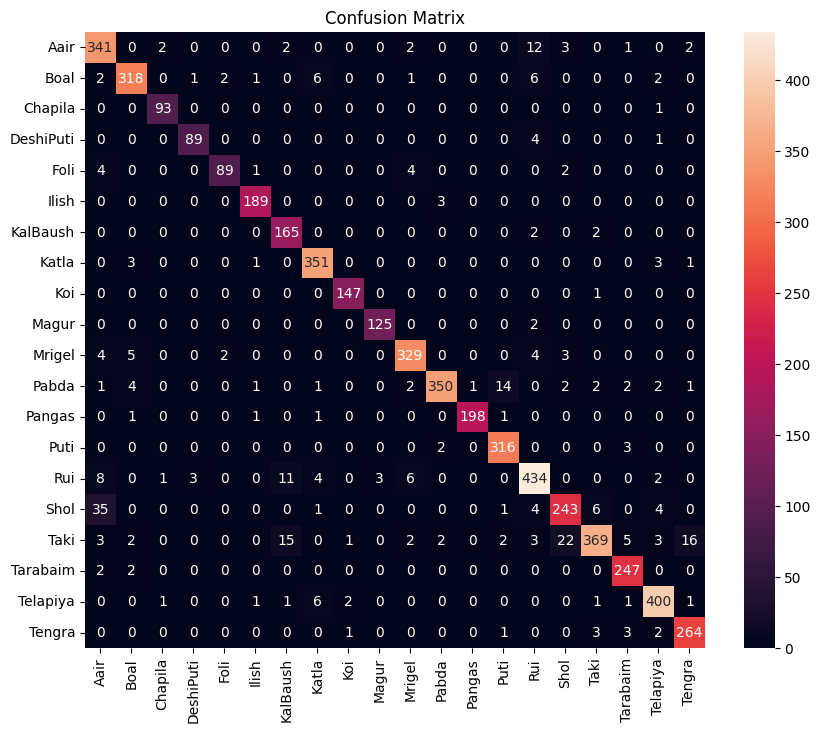

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_ft.eval()
true_labels, pred_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model_ft(x)
        preds = torch.argmax(out, dim=1).cpu().numpy()
        true_labels.extend(y.numpy())
        pred_labels.extend(preds)

# Accuracy and classification report
print("Accuracy:", accuracy_score(true_labels, pred_labels))
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=full_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title("Confusion Matrix")
plt.show()


In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# One-hot encoding
y_true_bin = label_binarize(true_labels, classes=range(len(full_dataset.classes)))
y_score = []

model_ft.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model_ft(x)
        y_score.extend(out.cpu().numpy())

y_score = np.array(y_score)
print("Macro AUC:", roc_auc_score(y_true_bin, y_score, average="macro", multi_class='ovr'))


Macro AUC: 0.9893084146172964


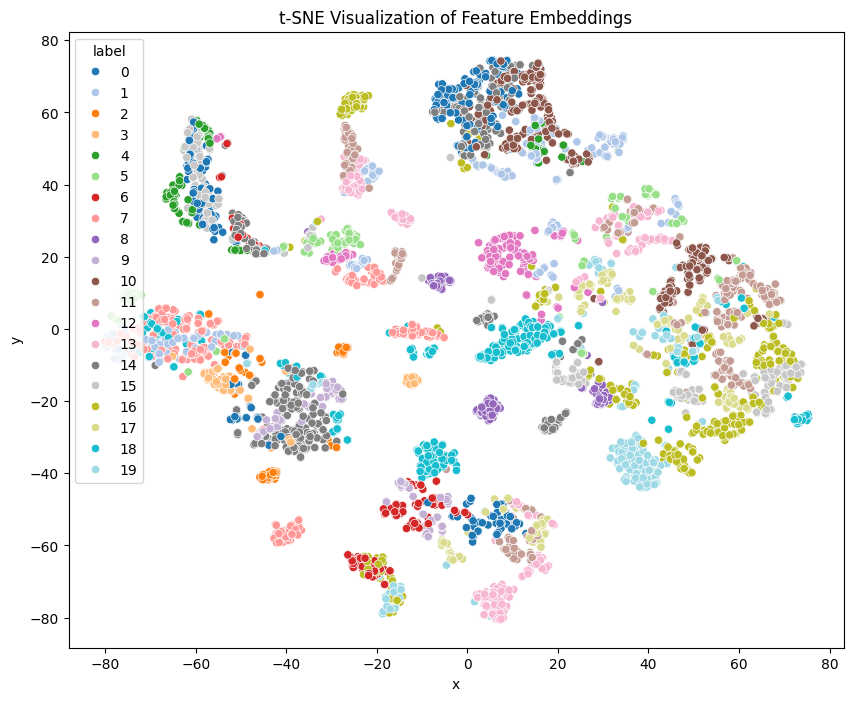

In [20]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert features list to NumPy array
features = np.array(features)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42).fit_transform(features)

# Make a dataframe for visualization
df = pd.DataFrame(tsne, columns=["x", "y"])
df["label"] = labels

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="x", y="y", hue="label", palette="tab20", legend="full")
plt.title("t-SNE Visualization of Feature Embeddings")
plt.show()
